# ノート 8 : 複数のモデルを使った ML

### 目標 論文で紹介したすべての ML モデルを使って複数の特徴量/予測変数/入力変数を使った学習を行う

### 背景

論文で紹介した ML モデルは全て scikit-learn に実装されていて同じ手順のコードで適用することができます。
異なる ML モデルを学習させて比較することで取り組んでいる問題に対して最も性能がよい ML モデルを見つけます。
様々な手法の ML モデルを扱えるようになるとこれから ML を適用したプロジェクトを作ろうとする場合に役に立つでしょう。


### 1 つの特徴量を使った分類問題

ノート 4 と同じ手順で進めます。


In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

import warnings

warnings.filterwarnings("ignore")


%config InlineBackend.figure_format = 'retina'


import sys

sys.path.insert(1, "../scripts/")
from aux_functions import load_n_combine_df

In [2]:
(X_train, y_train), (X_validate, y_validate), (X_test, y_test) = load_n_combine_df(
    path_to_data="../datasets/sevir/",
    features_to_keep=np.arange(0, 1, 1),  # 1つの特徴量だけ
    class_labels=True,  # ラベルをクラス化する
)

モデルを初期化します。ML 手法に対応したクラスを使うだけです。


In [3]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

model_list = [
    LogisticRegression(),  # ロジスティック回帰
    GaussianNB(),  # 確率分布がガウス分布のナイーブベイズ
    DecisionTreeClassifier(),  # 決定木
    RandomForestClassifier(),  # ランダムフォレスト
    GradientBoostingClassifier(),  # 勾配ブースト決定木
    LinearSVC(dual=False),  # サポートベクトルマシン（線形カーネル、双体問題を解かない）
]

pprint(model_list)

[LogisticRegression(),
 GaussianNB(),
 DecisionTreeClassifier(),
 RandomForestClassifier(),
 GradientBoostingClassifier(),
 LinearSVC(dual=False)]


学習も全く同じコードになります。それぞれのモデルを学習させましょう。
全てのモデルの学習が終わるまで 1 分程度かかります。


In [4]:
import tqdm  # ループの進行具合を示すパッケージ

for model in tqdm.tqdm(model_list):
    model.fit(X_train, y_train)

100%|██████████| 6/6 [00:55<00:00,  9.20s/it]


ノート 9 で利用するために学習済みモデルを永続化しておきましょう。
特に決定木モデルのファイルサイズが大きくなるのでレポジトリ登録のために圧縮しています。


In [5]:
import pickle
import bz2
from pathlib import Path

save_dir = Path("../datasets/sklearnmodels/classification/onefeature")
save_files = [
    save_dir / "LogisticRegression.pkl",
    save_dir / "NaiveBayes.pkl",
    save_dir / "DecisionTree.pkl.bz2",
    save_dir / "RandomForest.pkl.bz2",
    save_dir / "GradientBoostedTrees.pkl.bz2",
    save_dir / "SupportVectorMachines.pkl",
]
if not save_dir.exists():
    save_dir.mkdir(parents=True)
for model, save_file in zip(model_list, save_files):
    if save_file.suffix == ".bz2":
        with bz2.open(save_file, "wb") as f:
            pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(save_file, "wb") as f:
            pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

学習をスキップした場合は学習済みデータを次のコードで読み込みます。


In [8]:
import pickle
from pathlib import Path
import bz2

save_dir = Path("../datasets/sklearnmodels/classification/onefeature")
save_files = [
    save_dir / "LogisticRegression.pkl",
    save_dir / "NaiveBayes.pkl",
    save_dir / "DecisionTree.pkl.bz2",
    save_dir / "RandomForest.pkl.bz2",
    save_dir / "GradientBoostedTrees.pkl.bz2",
    save_dir / "SupportVectorMachines.pkl",
]

model_list = []

for save_file in save_files:
    if save_file.suffix == ".bz2":
        with bz2.open(save_file, "rb") as f:
            model = pickle.load(f)
    else:
        with open(save_file, "rb") as f:
            model = pickle.load(f)
    model_list.append(model)

pprint(model_list)

[LogisticRegression(),
 GaussianNB(),
 DecisionTreeClassifier(),
 RandomForestClassifier(),
 GradientBoostingClassifier(),
 LinearSVC(dual=False)]


これで 6 つのモデルの学習が終わりました。評価と検証を行いましょう。まずはパフォーマンスダイアグラムを描いてみます。


LgR accuracy: 81.0%
NB accuracy: 80.0%
DT accuracy: 80.0%
RF accuracy: 80.0%
GBT accuracy: 80.0%
SVM accuracy: 81.0%


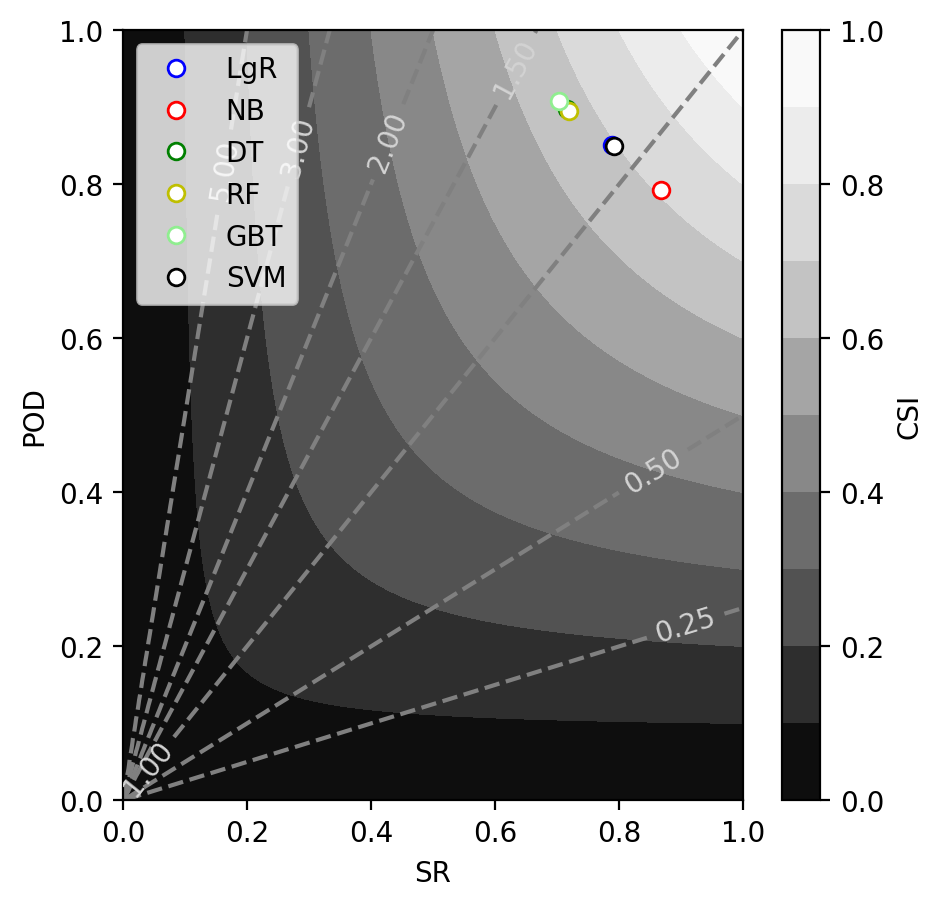

In [9]:
# ユーティリティ関数の読み込み
from gewitter_functions import (
    get_contingency_table,
    make_performance_diagram_axis,
    get_acc,
    get_pod,
    get_sr,
)


def plot_performance_diagram_classification(model_list):
    # パフォーマンスダイアグラムのAxesオブジェクト
    ax = make_performance_diagram_axis()

    # 色とラベルのリスト
    colors = ["b", "r", "g", "y", "LightGreen", "k"]
    legend_labels = ["LgR", "NB", "DT", "RF", "GBT", "SVM"]

    for idx, model in enumerate(model_list):
        # 検証データからの予測
        yhat = model.predict(X_validate)
        # 分割表を計算
        cont_table = get_contingency_table(y_validate, yhat)

        # 指標を求める
        accuracy = get_acc(cont_table)
        pod = get_pod(cont_table)
        sr = get_sr(cont_table)

        ax.plot(sr, pod, "o", c=colors[idx], mfc="w", label=legend_labels[idx])
        print("{} accuracy: {}%".format(legend_labels[idx], np.round(accuracy, 0)))

    ax.legend()


plot_performance_diagram_classification(model_list)

論文でも比較した通り 6 つの ML 手法はわずかな違いはありますが基本的には同じ性能を示しています。
ROC 曲線の AUC を見ても同じような結果が得られるでしょう。
ここで使った SVM（線形 SVM）モデルクラスは `predict_proba` メソッドをサポートしていないので SVM 以外の ROC 曲線を描いてみます。


LgR AUC: 0.9
NB AUC: 0.89
DT AUC: 0.89
RF AUC: 0.89
GBT AUC: 0.9


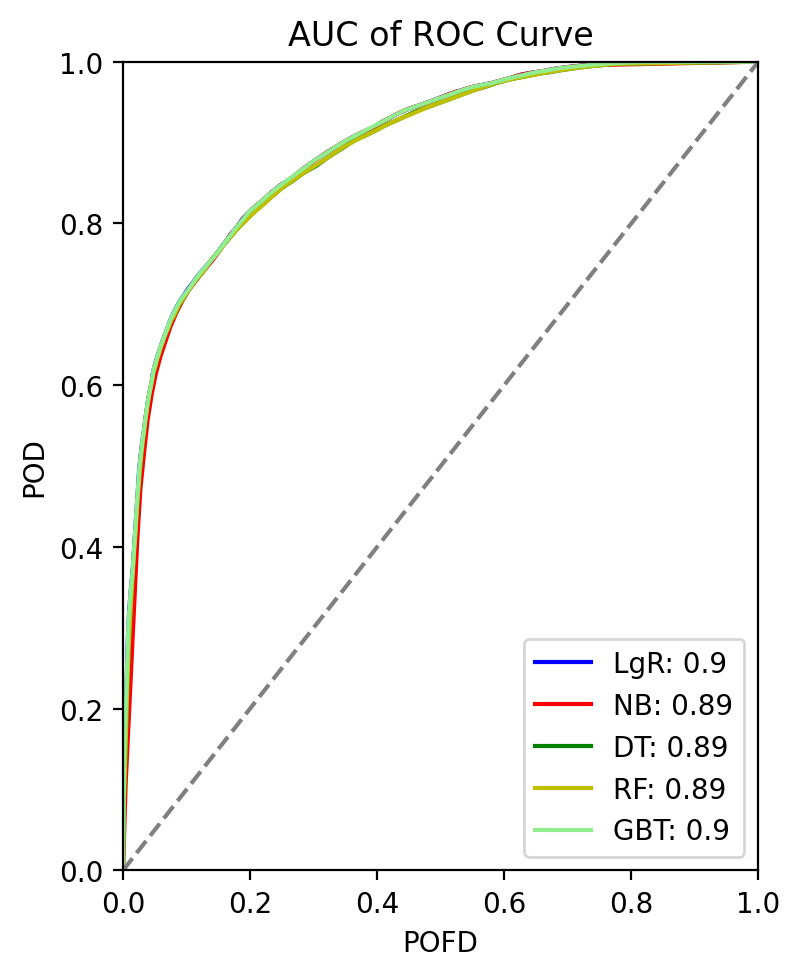

In [14]:
# ユーティリティ関数
from gewitter_functions import get_points_in_roc_curve, get_area_under_roc_curve


def plot_roc_classification(model_list):
    fig, ax = plt.subplots(figsize=(4.1, 5))

    # プロットの色とラベル
    colors = ["b", "r", "g", "y", "LightGreen", "k"]
    legend_labels = ["LgR", "NB", "DT", "RF", "GBT", "SVM"]

    for idx, model in enumerate(model_list[:-1]):
        # 検証データからの予測される分類確率
        yhat_proba = model.predict_proba(X_validate)

        # クラス1の予測でプロット（2分類問題なのでクラス0とクラス1の確率の和は1）
        y_preds = yhat_proba[:, 1]

        # ROC曲線の計算
        pofds, pods = get_points_in_roc_curve(
            forecast_probabilities=y_preds,
            observed_labels=y_validate,
            threshold_arg=np.linspace(0, 1, 100),
        )
        # AUCの計算
        auc = get_area_under_roc_curve(pofds, pods)

        ax.plot(
            pofds,
            pods,
            "-",
            color=colors[idx],
            label=f"{legend_labels[idx]}: {np.round(auc, 2)}",
        )

        print("{} AUC: {}".format(legend_labels[idx], np.round(auc, 2)))

    ax.legend(loc="lower right")

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    ax.plot([0, 1], [0, 1], "--", color="Grey")

    ax.set_title("AUC of ROC Curve")
    ax.set_xlabel("POFD")
    ax.set_ylabel("POD")

    fig.tight_layout()


plot_roc_classification(model_list)

複数の ML モデルについて学習と評価を行うことができました。全ての特徴量を用いた場合の ML モデルの比較についても行ってみてください。


### 1 つの特徴量を用いた回帰問題

ノート 5 と同様の手順で回帰問題を複数の ML モデルで学習させます。


In [8]:
import matplotlib.pyplot as plt 
import numpy as np

%config InlineBackend.figure_format = 'retina'

import sys
sys.path.insert(1, '../scripts/')
from aux_functions import load_n_combine_df

(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(
    path_to_data='../datasets/sevir/',
    features_to_keep=np.arange(0,1,1), # インデックス[0]の特徴量だけ
    class_labels=False, # ラベルを二値にしない
    dropzeros=True # 発雷数ぜロのデータを削除
    )

回帰モデルを初期化します。


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR

# initialize
model_list = [
    LinearRegression(),  # 線形回帰
    DecisionTreeRegressor(),  # 決定木
    RandomForestRegressor(),  # ランダムフォレスト
    GradientBoostingRegressor(),  # 勾配ブースト決定木
    LinearSVR(),  # 線形SVM
]

pprint(model_list)

[LinearRegression(),
 DecisionTreeRegressor(),
 RandomForestRegressor(),
 GradientBoostingRegressor(),
 LinearSVR()]


学習させます。全てのモデルの学習が終わるまで 1 分程度かかります。


In [10]:
import tqdm  # ループの進行具合を表示するため

for model in tqdm.tqdm(model_list):
    model.fit(X_train, y_train)

100%|██████████| 5/5 [00:26<00:00,  5.23s/it]


学習済みモデルを永続化しておきましょう。
特に決定木モデルのファイルサイズが大きくなるのでレポジトリ登録のために圧縮しています。


In [11]:
import pickle
from pathlib import Path
import bz2

save_dir = Path("../datasets/sklearnmodels/regression/onefeature")
save_files = [
    save_dir / "LinearRegression.pkl",
    save_dir / "DecisionTree.pkl.bz2",
    save_dir / "RandomForest.pkl.bz2",
    save_dir / "GradientBoostedTrees.pkl.bz2",
    save_dir / "SupportVectorMachines.pkl",
]
if not save_dir.exists():
    save_dir.mkdir(parents=True)
for model, save_file in zip(model_list, save_files):
    if save_file.suffix == ".bz2":
        with bz2.open(save_file, "wb") as f:
            pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(save_file, "wb") as f:
            pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

論文の図 14、16 のような散布図を描いて比較しましょう。


In [12]:
# ユーティリティ関数
from aux_functions import boxbin, make_colorbar


def plot_scatter_regression(model_list):
    fig, axes = plt.subplots(2, 3, figsize=(7.5, 5))

    # 散布図の密度は33分割して計算
    n = 33
    xbins = np.logspace(0, 3.5, n)
    ybins = np.logspace(0, 3.5, n)

    # 色とラベル
    labels = ["LnR", "DT", "RF", "GBT", "SVM"]
    colors = ["r", "b", "orange", "purple", "dimgrey"]
    cmaps = ["Reds_r", "Blues_r", "Oranges_r", "Purples_r", "Greys_r"]

    # Axesのリストをループしやすいように変形
    axes = axes.ravel()

    # draw a new axis for a new colorbar to go on
    ax_cbar = fig.add_axes([0.75, 0.15, 0.015, 0.33])
    # draw that colorbar
    cbar = make_colorbar(ax_cbar, 0, 2, plt.cm.Greys_r)
    # label that colorbar
    cbar.set_label("$\%$ of total points")

    axes[5].axis("off")  # 6番目のAxesは描画しない
    for i, ax in enumerate(axes[:5]):
        # ログスケールにする
        ax.semilogy()
        ax.semilogx()

        # 検証データから予測
        model = model_list[i]
        yhat = model.predict(X_validate)

        # 散布図
        ax.scatter(yhat, y_validate, color=colors[i], s=1, marker="+")

        # 密度をプロット
        ax, cbar, _ = boxbin(
            yhat,
            y_validate,
            xbins,
            ybins,
            ax=ax,
            mincnt=100,
            normed=True,
            cmap=cmaps[i],
            vmin=0,
            vmax=2,
            cbar=False,
        )

        # 軸とメモリの設定
        ax.set_xlim([1, 4000])
        ax.set_xticks([1, 10, 100, 1000])
        ax.set_yticks([1, 10, 100, 1000])
        ax.set_ylim([1, 4000])

        # 対角線
        ax.plot([1, 4000], [1, 4000], "--k", alpha=0.5)

        if (i == 0) or (i == 3):
            ax.set_ylabel(r"$y$, [# of flashes]")
        if i == 4:
            ax.set_xlabel(r"$\hat{y}$, [# of flashes]")

        ax.set_title(labels[i])

    fig.tight_layout()

n_samples= 33529.0
n_samples= 35713.0
n_samples= 35729.0
n_samples= 37345.0
n_samples= 35256.0


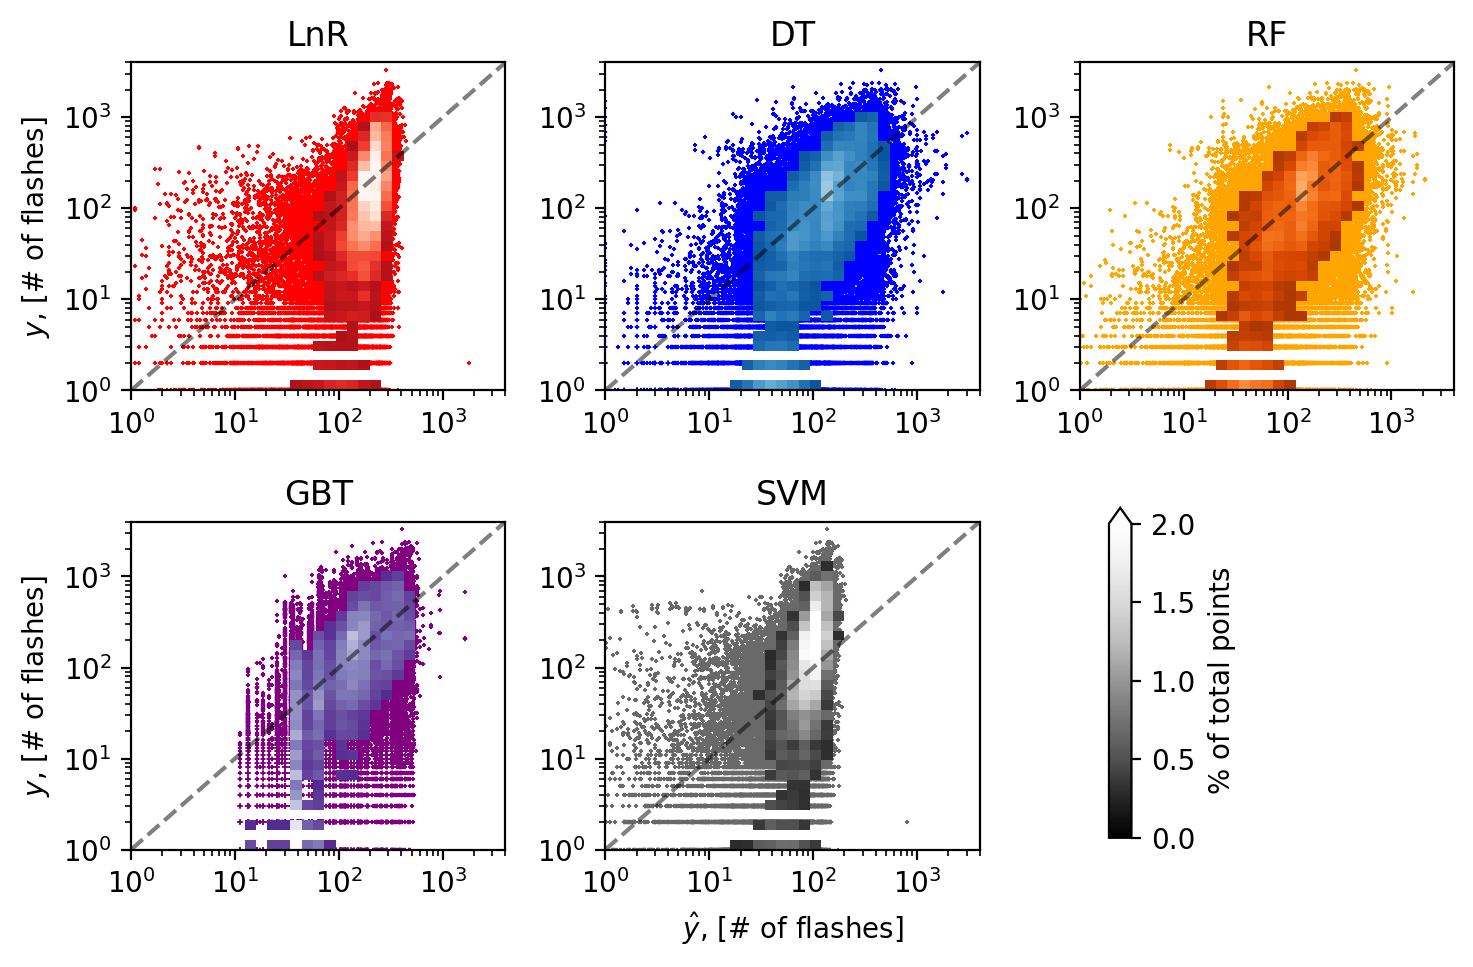

In [13]:
plot_scatter_regression(model_list)

他の指標も計算します。


In [14]:
# ユーティリティ関数
from gewitter_functions import get_mae, get_rmse, get_bias, get_r2

labels = ["LnR", "DT", "RF", "GBT", "SVM"]
for idx, model in enumerate(model_list):
    # 検証データからの予測
    yhat = model.predict(X_validate)

    mae = get_mae(y_validate, yhat)
    rmse = get_rmse(y_validate, yhat)
    bias = get_bias(y_validate, yhat)
    r2 = get_r2(y_validate, yhat)

    # print them out so we can see them
    print(
        "Method: {} .. MAE:{} flashes, RMSE:{} flashes, Bias:{} flashes, Rsquared:{}".format(
            labels[idx],
            np.round(mae, 2),
            np.round(rmse, 2),
            np.round(bias, 2),
            np.round(r2, 2),
        )
    )

Method: LnR .. MAE:131.15 flashes, RMSE:202.35 flashes, Bias:6.49 flashes, Rsquared:0.19
Method: DT .. MAE:128.37 flashes, RMSE:212.55 flashes, Bias:0.99 flashes, Rsquared:0.11
Method: RF .. MAE:127.89 flashes, RMSE:210.21 flashes, Bias:0.99 flashes, Rsquared:0.13
Method: GBT .. MAE:125.01 flashes, RMSE:203.01 flashes, Bias:1.03 flashes, Rsquared:0.18
Method: SVM .. MAE:117.81 flashes, RMSE:222.27 flashes, Bias:76.19 flashes, Rsquared:0.02


指標をプロットして比較しましょう。論文の図 15 と 17 を作成します。


In [15]:
# ユーティリティ関数
from gewitter_functions import get_mae, get_rmse, get_bias, get_r2


def plot_metrics_regression(model_list):
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))

    labels = ["LnR", "DT", "RF", "GBT", "SVM"]
    colors = ["r", "b", "orange", "purple", "dimgrey"]
    labels = ["LnR", "DT", "RF", "GBT", "SVM"]

    for i, model in enumerate(model_list):
        # 検証データからの予測
        yhat = model.predict(X_validate)
        # 指標
        mae = get_mae(y_validate, yhat)
        rmse = get_rmse(y_validate, yhat)
        bias = get_bias(y_validate, yhat)
        r2 = get_r2(y_validate, yhat)

        ############### subplot 0,0: Bias ########################
        ax = axes[0, 0]
        # 棒グラフの位置をモデル毎にずらす
        ax.bar(i, bias, width=0.95, color=colors[i])
        # 値をテキストでプロット
        annotate = str(int(np.round(bias))).rjust(3, " ")
        ax.text(i - 0.4, bias + 5, annotate)

        ####### subplot 0,1: Mean Absolute Error #################
        ax = axes[0, 1]
        ax.bar(i, mae, width=0.95, color=colors[i])
        annotate = str(int(np.round(mae))).rjust(3, " ")
        ax.text(i - 0.4, mae + 5, annotate)

        ####### subplot 1,0: Root Mean Squared Error #############
        ax = axes[1, 0]
        ax.bar(i, rmse, width=0.95, color=colors[i])
        annotate = str(int(np.round(rmse))).rjust(3, " ")
        ax.text(i - 0.4, rmse + 5, annotate)

        ####### subplot 1,1: Rsquared ###########################
        ax = axes[1, 1]
        ax.bar(i, r2, width=0.95, color=colors[i])
        annotate = str(np.round(r2, 2)).ljust(4, "0")
        ax.text(i - 0.5, r2 + 0.05, annotate)

    ax = axes[0, 0]
    ax.xaxis.set_ticks(np.arange(0, 5))
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.set_ylim([-130, 130])
    ax.set_title("Bias")

    ax = axes[0, 1]
    ax.set_ylim([0, 200])
    ax.xaxis.set_ticks(np.arange(0, 5))
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.set_title("Mean Abs. Error")

    ax = axes[1, 0]
    ax.set_ylim([0, 300])
    ax.xaxis.set_ticks(np.arange(0, 5))
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.set_title("Root Mean Sq. Error")

    ax = axes[1, 1]
    ax.set_ylim([-1, 1])
    ax.xaxis.set_ticks(np.arange(0, 5))
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.set_title("$R^{2}$")

    fig.tight_layout()

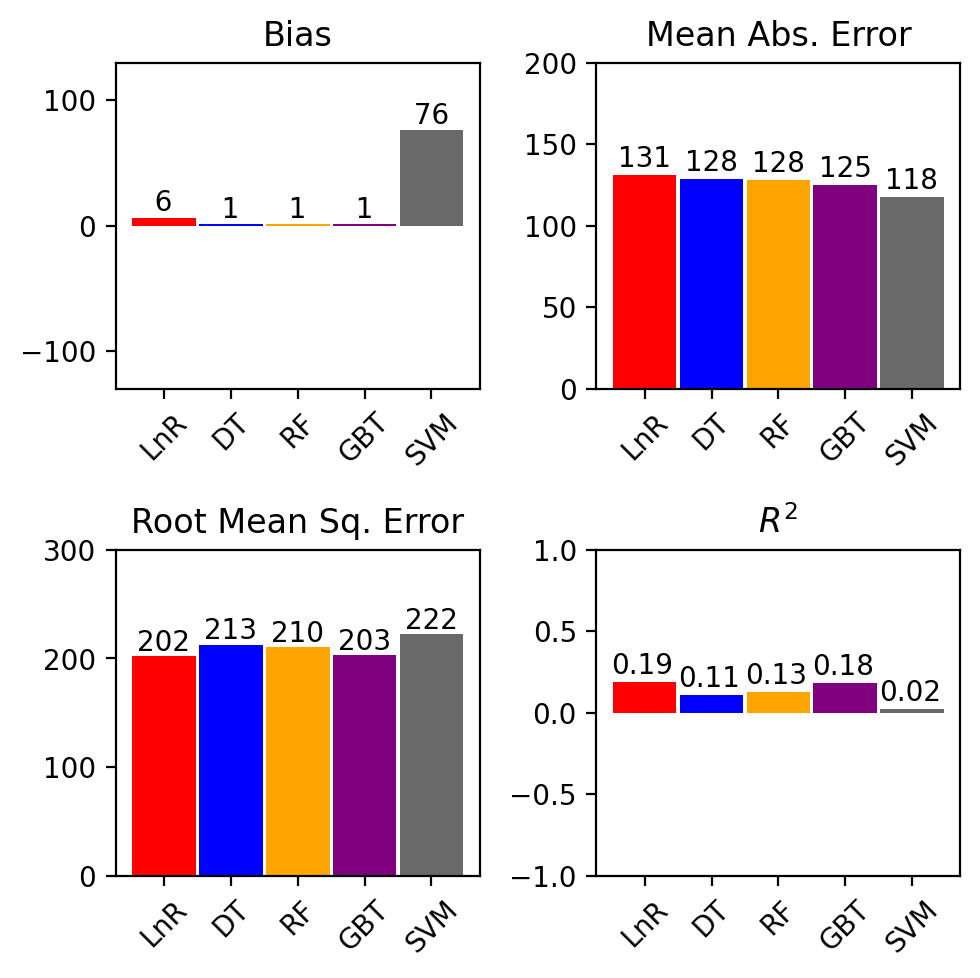

In [16]:
plot_metrics_regression(model_list)

5 種類の ML モデルの指標を比較するプロットが作成できました。特徴量を増やした場合の回帰問題についても挑戦してみましょう。
